# Adult Dataset
The main goal of this project is to build a classifier that predicts the income class of an individual with respect to various input features.

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data loading and preprocessing
The major part of building a model is data preprocesing. In the following, we load the data and perform various data cleaning steps.

In [12]:
# Read 'adult.csv' file and rename the missing values as NAN
data = pd.read_csv('adult.csv', na_values = ['#NAME?','?'])
data.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


In [13]:
income_count = data['income'].value_counts()
print(income_count)

<=50K    37155
>50K     11687
Name: income, dtype: int64


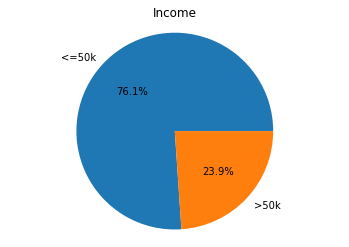

In [14]:
income_labels = ['<=50k', '>50k']
plt.pie(income_count, labels = income_labels, autopct='%1.1f%%')
plt.title('Income')
plt.axis('equal')
plt.show()

The pie chart helps us to visualize the ratio between the income types.

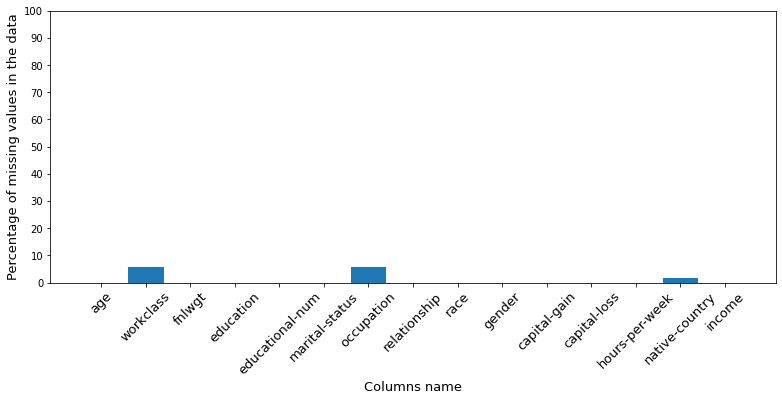

In [15]:
plt.figure(figsize = (13,5))
plt.bar(data.columns, (data.isna().sum()/data.shape[0])*100)
plt.xticks(rotation=45, fontsize = 13)
plt.yticks(np.arange(0,110,10))
plt.xlabel("Columns name", fontsize = 13)
plt.ylabel("Percentage of missing values in the data", fontsize = 13)
plt.show()

In the plot above, the bar plots for the percentage of missing values with respect to the columns are displayed. Since, the percentage of missing values are less than 10% for each column, we drop the rows with the missing values. 

In [16]:
# Drop the rows with missing values
data.dropna(inplace = True)
data.reset_index(drop = True, inplace = True)

In [17]:
# Encode the 'income' column 
data['income'] = [0 if x == '<=50K' else 1 for x in data['income']]


In [18]:
# split the dataframe into input attributes and output label
X = data.drop('income', 1)
y = data.income

In [19]:
# Display the number of categories in various features in order to determine further preprocessing

for column in X.columns:
    if X[column].dtypes == 'object':
        unique_category = len(X[column].unique())
        print("Feature: {0}, Number of unique categories: {1}".format(column,unique_category))
        

Feature: workclass, Number of unique categories: 7
Feature: education, Number of unique categories: 16
Feature: marital-status, Number of unique categories: 7
Feature: occupation, Number of unique categories: 14
Feature: relationship, Number of unique categories: 6
Feature: race, Number of unique categories: 5
Feature: gender, Number of unique categories: 2
Feature: native-country, Number of unique categories: 41


Here, we observe that the feature native-country has 41 unique categories. We need to investigate further in order to determine if we could reduce that number.

In [20]:
print(X['native-country'].value_counts().sort_values(ascending=False).head(10))

United-States    41292
Mexico             903
Philippines        283
Germany            193
Puerto-Rico        175
Canada             163
India              147
El-Salvador        147
Cuba               133
England            119
Name: native-country, dtype: int64


In [21]:
print("{:.2f} percent".format((X['native-country'].value_counts()['United-States']/len(X['native-country']))*100))

91.31 percent


For the feature native-country, we observe that the 'United-States' dominate other countries. 91.31 percent of the data belongs to the 'United-States' category. Therfore, we assign 'Other' category for the remaning countries.

In [22]:
X['native-country'] = ['United-States' if x == 'United-States' else 'Other' for x in X['native-country']]
print(X['native-country'].value_counts().sort_values(ascending = False))

United-States    41292
Other             3930
Name: native-country, dtype: int64


In [23]:
# Since the education and educational-num gives us the same information, we drop one of the columns
X.drop('educational-num',1 , inplace = True)
X.head()

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country
0,25,Private,226802,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States
1,38,Private,89814,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States
2,28,Local-gov,336951,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States
3,44,Private,160323,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States
4,34,Private,198693,10th,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States


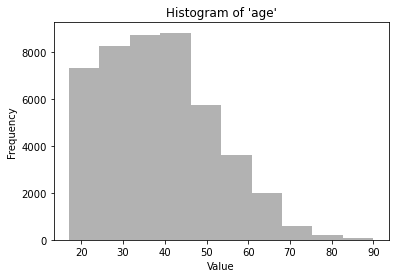

In [24]:
# The following histogram shows us the frequency distribution for 'age' category. 
plt.hist(X['age'], color = 'gray', alpha = 0.6)
plt.title("Histogram of '{0}'".format('age'))
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In the above histogram, we see that people in the age group 20-40 earn more income compared to the other age group. 

Histograms help us to observe the frequency distribution. If we observe that the distribution has outliers, we can further study the data for outliers using box plots. Outliers are removed from the data based on specific questions being asked about the data. For this modeling project the outliers are not removed, since they are natural part of the population. 

### One Hot Encoding
Since machine learning algorithms can only take numerical entries, we need to change the categorical data in numerical. To do so we use One Hot Encoding in Scikit-Learn.

In [25]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

ToDummyList = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']
# We drop the first column after encoding the feature
ct = ColumnTransformer(transformers = [('encoder', OneHotEncoder(drop = 'first', sparse = True), ToDummyList)], remainder = 'passthrough')
X = ct.fit_transform(X)

# X is a scipy sparse matrix
print(X[0])

  (0, 1)	1.0
  (0, 6)	1.0
  (0, 24)	1.0
  (0, 32)	1.0
  (0, 42)	1.0
  (0, 46)	1.0
  (0, 49)	1.0
  (0, 50)	1.0
  (0, 51)	25.0
  (0, 52)	226802.0
  (0, 55)	40.0


### Splitting the dataset into the Training set and Test set

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

# converting scipy sparse matrix to numpy array
X_train = X_train.toarray()
X_test = X_test.toarray()

#converting series to numpy array
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

print(X_train[0])

[0.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 1.00000e+00 2.80000e+01 1.79949e+05 0.00000e+00
 0.00000e+00 2.00000e+01]


### Feature Scaling
Next, we need to normalize the values so that the machine learning algorithm learns the features more accurately.

In [27]:
# feature scaling in columns 51 to 55 (columns except the ecoded ones)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

#normalize_columns = ['age','fnlwgt','capital-gain','capital-loss','hours-per-week']


X_train[:,51:] = sc.fit_transform(X_train[:,51:])
X_test[:,51:] = sc.fit_transform(X_test[:,51:])
print(X_train[0])

[ 0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          1.          0.          0.          1.          0.
  0.          0.          1.         -0.79527553 -0.09230026 -0.14620721
 -0.21884527 -1.74323948]


# Random Forest Classification

In [28]:
from sklearn.ensemble import RandomForestClassifier
Clf = RandomForestClassifier(n_estimators = 100, random_state = 0)
Clf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [29]:
y_pred = Clf.predict(X_test)

In [30]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

print(f"Accuracy: {accuracy_score(y_test,y_pred)*100:.2f}")
print(f"F1 score: {f1_score(y_test, y_pred):.4f}")

Accuracy: 84.49
F1 score: 0.6610


### Hyperparameter Tuning
In the following cell we tune the hyper parameters for the random forest. 

In [31]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 40, stop = 150, num = 12)]
max_depth = [int(x) for x in np.linspace(40, 150, num = 12)]

param_dist = {
    'n_estimators' : n_estimators,
    'max_depth' : max_depth,
}

tuned_Clf = RandomForestClassifier(random_state = 0)
cv_Clf = RandomizedSearchCV(estimator = tuned_Clf, param_distributions = param_dist, cv = 5, random_state = 0)

cv_Clf.fit(X_train, y_train)
cv_Clf.best_score_


0.8539883114831781

In [32]:
# hyperparameters for the best model
cv_Clf.best_params_


{'n_estimators': 110, 'max_depth': 40}

In [34]:
best_Clf = RandomForestClassifier(max_depth = 40, n_estimators = 110, random_state = 0)
best_Clf.fit(X_train, y_train)
y_pred_best_Clf = best_Clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test,y_pred_best_Clf)*100:.2f}")
print(f"F1 score: {f1_score(y_test, y_pred_best_Clf):.4f}")


Accuracy: 84.83
F1 score: 0.6647


#### Confusion Matrix
In the following cell we compute the confusion matrix for the best classifier obtained from hyperparameter tuning.

In [35]:
from sklearn.metrics import confusion_matrix 
cm = confusion_matrix(y_test, y_pred_best_Clf)
print(cm)

[[9469  723]
 [1335 2040]]


<AxesSubplot:>

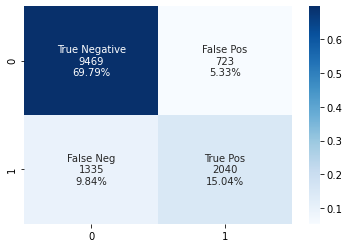

In [36]:
import seaborn as sns 
group_names = ['True Negative','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm/np.sum(cm), annot = labels, fmt = '', cmap= 'Blues')